In [13]:
from sklearn.metrics import cohen_kappa_score
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim 
from time import time
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

In [14]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion *
                            planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        #in channels (1), 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=11, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #print(out)
        #print(type(out))
        #print(out.shape)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

class FeatureDataset(Dataset):
  
  def __init__(self, file_name):
    self.x_train = []
    self.y_train = []
    self.X_train = []
    self.Y_train = []

    count = 0
    
    """name = {
        'Large': 0,
        'Small': 1,
    }"""
    name = {
       'Pre-RDT RM 1.0': 0,
         'Pre-RDT RM 2.0': 1,
            'Pre-RDT RM 3.0': 2,
            'RDT D1 1.0': 3,
            'RDT D1 2.0': 4,
            'RDT D1 3.0': 5,
    }
    """for root,dirs,files in os.walk(file_name):
      print(dirs)
      y = name[dirs]
      for name in files:"""
    #read csv file and load row data into variables
    for subdir in os.listdir(file_name):
      for fname in os.listdir(os.path.join(file_name, subdir)):
        full_path = os.path.join(file_name, subdir, fname)
        y = name[subdir]
        #filename = os.path.join(root,name)
        file_out = pd.read_csv(full_path, header = None) #if don't say header is none, first row will be used as header
        file_out = file_out.iloc[:,1:]
        x = file_out.iloc[0:len(file_out), 0:len(file_out)].values
        x = x[1:].astype(np.float32) # ommitting the column headers (cell names)
        #print(x[0])
        self.x_train.append(x)
        #print("x_train:", x_train)
        # y = file_out.iloc[0:32, 0:32].values
        self.y_train.append(y)
        #Converting to tensors
        X = torch.tensor(x, dtype=torch.float32) #converting to tensors (used to be self.X_train)
        self.X_train.append(X)
        #print("X_train size: ",X_train.shape)
        Y = torch.tensor(y)
        #print("Y_train size: ",Y_train.shape)
        self.Y_train.append(Y)
        count += 1
        #print(count)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.X_train[idx], self.Y_train[idx]

cuda available


/home/rory/anaconda3/envs/pyTorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Epoch: 0 | Training Loss: 0.432758 | Val. Loss: 3.067774 | Val. Kappa Score: nan
Validation loss decreased (inf --> 3.067774).  Saving model ...
Epoch: 1 | Training Loss: 0.572786 | Val. Loss: 4.079933 | Val. Kappa Score: nan
Epoch: 2 | Training Loss: 0.521411 | Val. Loss: 3.722207 | Val. Kappa Score: nan
Epoch: 3 | Training Loss: 0.515052 | Val. Loss: 3.674855 | Val. Kappa Score: nan
Epoch: 4 | Training Loss: 0.490943 | Val. Loss: 3.503647 | Val. Kappa Score: nan
Epoch: 5 | Training Loss: 0.514012 | Val. Loss: 3.666087 | Val. Kappa Score: nan
Epoch: 6 | Training Loss: 0.545385 | Val. Loss: 3.889525 | Val. Kappa Score: nan
Epoch: 7 | Training Loss: 0.519415 | Val. Loss: 3.706843 | Val. Kappa Score: nan
Epoch: 8 | Training Loss: 0.500748 | Val. Loss: 3.573361 | Val. Kappa Score: nan
Epoch: 9 | Training Loss: 0.504160 | Val. Loss: 3.596694 | Val. Kappa Score: nan
Epoch: 10 | Training Loss: 0.470542 | Val. Loss: 3.358527 | Val. Kappa Score: nan
Epoch: 11 | Training Loss: 0.497234 | Val. L

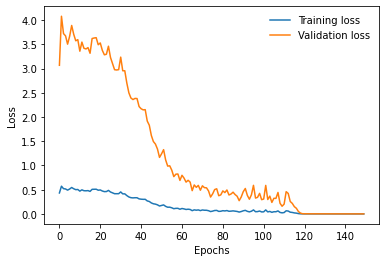

In [21]:
train_set = FeatureDataset("/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_69_100_v2/train")
test_set = FeatureDataset("/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_69_100_v2/test")
val_set = FeatureDataset("/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_69_100_v2/val")

test_set.X_train

mini_batch_size = 1
trainloader = torch.utils.data.DataLoader(train_set, batch_size=mini_batch_size)
testloader = torch.utils.data.DataLoader(test_set, batch_size=mini_batch_size)
valloader = torch.utils.data.DataLoader(val_set, batch_size=mini_batch_size)
cats = ["Pre-RDT RM 1.0", "Pre-RDT RM 2.0","Pre-RDT RM 3.0", "RDT D1 1.0", "RDT D1 2.0","RDT D1 3.0"]

train_losses = []
valid_losses = []
val_kappa = []
test_accuracies = []
valid_accuracies = []
kappa_epoch = []
time0 = time()

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda available")
else:
    device = torch.device('cpu')
    print("cpu")

model = ResNet18()
#model = resnet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device)

def train(epochs, model):
    valid_loss_min = np.Inf
    train_loss = 0.0
    valid_loss = 0.0
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            #print(images)
            #print(labels)
            images = images.unsqueeze(1)
            #print(images.shape)
            #long(images) convert types
            images = images.to(device)
            #print(images.shape)
            labels = labels.to(device)
    
            # Training pass
            optimizer.zero_grad()
    
            output = model(images).to(device)
        
            loss = criterion(output, labels)
    
            # backpropagation: calculate the gradient of the loss function w.r.t model parameters
            loss.backward()
    
            # And optimizes its weights here
            optimizer.step()
    
            running_loss += loss.item()
            
            train_loss += loss.item()*images.size(0)
            valid_loss += loss.item()*images.size(0)
            
            y_actual = labels.data.cpu().numpy()
            y_pred = output[:,-1].detach().cpu().numpy()
            val_kappa.append(cohen_kappa_score(y_actual, y_pred.round()))  
        else:
            
            train_loss = train_loss/len(trainloader.sampler)
            valid_loss = valid_loss/len(valloader.sampler)
            valid_kappa = np.mean(val_kappa)
            kappa_epoch.append(np.mean(val_kappa))
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            print('Epoch: {} | Training Loss: {:.6f} | Val. Loss: {:.6f} | Val. Kappa Score: {:.4f}'.format(
                e, train_loss, valid_loss, valid_kappa))
            
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), '/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_69_100/trained_model_150.pt')
                valid_loss_min = valid_loss
    print("\nTraining Time (in minutes) =", (time()-time0)/60)


train(150, model)

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)


In [22]:
correct_count, all_count = 0, 0

correct = 0.00
total = 0.00

y_true = []
y_pred = []

with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.to(device)
        images = images.unsqueeze(1)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

"""with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.to(device)
        images = images.unsqueeze(1)
        #standard for image is 4 dimensional
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()"""

print('Accuracy of the network test images: %d %%' % (
    100 * correct / total))

torch.save(model.state_dict(), "/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_69_100/model_postbac_posterday_150.pt")
plt.show()

Accuracy of the network test images: 42 %


Confusion matrix, without normalization
[[ 2  5  2  0  0  0]
 [ 2  4  3  0  0  0]
 [ 1  2  6  0  0  0]
 [ 0  0  0 15  8 13]
 [ 0  0  0  5 16 15]
 [ 0  0  0  9 13 14]]


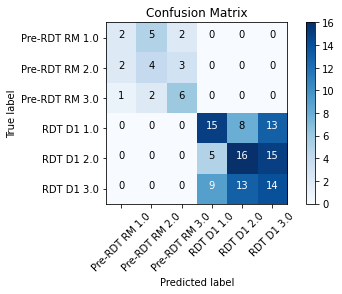

In [23]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#cm = confusion_matrix(y_true=cats, y_pred=np.argmax(correct/total, axis=-1))
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
#valloader.class_indices


plot_confusion_matrix(cm, classes=cats, title='Confusion Matrix')